# El Diagrama Hertzprung-Russell
### Agustín Vallejo
#### Preparación Regional para Olimpiadas de Astronomía **(PROA)**
#### 04-02-2019

Este programa usa una base de datos de 2847 estrellas con sus respectivas propiedades físicas, recopilada por Tim Kulogo y compartida para la realización de una actividad pedagógica.

El Script de ColourSystem fue adjuntado al código para obtener los colores reales de las estrellas a partir de sus respectivas temperaturas. Este subproceso se bajó de https://scipython.com/blog/converting-a-spectrum-to-a-colour/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import Wien, h, c, k

In [2]:
Ts = [] #Lista de Temperaturas Estelares
Ls = [] #Lista de Luminosidades Estelares
with open('data.csv',encoding="utf8") as fin:
    L = list(fin)
    for line in L[1:]:
        A = line.split(',')
        Ts.append(float(A[1]))
        Ls.append(10**float(A[-1])) 
        #Las Luminosidades fueron obtenidas indirectamente de la columna LogL pues los datos eran más completos

In [3]:
#Este es el script ColourSystem de https://scipython.com/blog/converting-a-spectrum-to-a-colour/
#Si se cuenta con Jupyter Lab, es recomendable minimizar esta celda porque es muy larga y rarita.
def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))

    def __init__(self, red, green, blue, white):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T 
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            # We're not in the RGB gamut: approximate by desaturating
            w = - np.min(rgb)
            rgb += w
        if not np.all(rgb==0):
            # Normalize the rgb vector
            rgb /= np.max(rgb)

        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ)
        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)
cs_hdtv = ColourSystem(red=xyz_from_xy(0.67, 0.33),
                       green=xyz_from_xy(0.21, 0.71),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs_smpte = ColourSystem(red=xyz_from_xy(0.63, 0.34),
                        green=xyz_from_xy(0.31, 0.595),
                        blue=xyz_from_xy(0.155, 0.070),
                        white=illuminant_D65)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

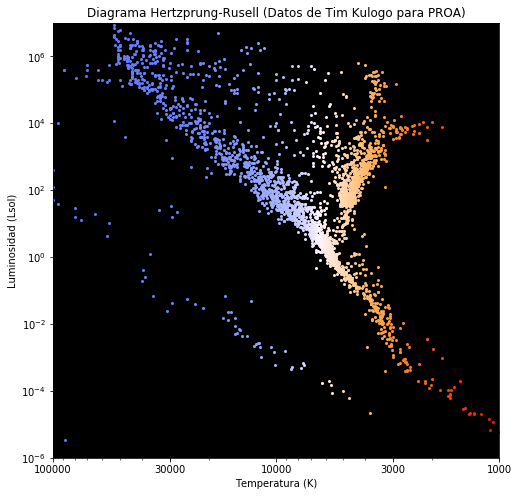

In [4]:
N = len(Ts)
NN = np.logspace(1,np.log10(N),100) #Se creó un array logarítmico para que la animación creciera exponencialmente
X = [1e3,3e3,1e4,3e4,1e5] #Los Ticks del eje X
X = [int(a) for a in X]   #Los Ticks vueltos enteros

for n in NN: #Cada vuelta del ciclo For descarga un frame de la animación
    plt.close('all')
    plt.figure(figsize=(8,8))
    for i in range(int(n)): #Cada vuelta del ciclo For grafica una estrella con su respectivo color
        lam = np.arange(380., 781., 5)
        spec = planck(lam, Ts[i])
        html_rgb = cs.spec_to_rgb(spec, out_fmt='html')

        plt.loglog(Ts[i],Ls[i],'o',markersize=2,color=html_rgb)
        plt.xlim([1e5,1e3])
        plt.xticks(X,X)
        plt.ylim([1e-6,1e7])
        plt.xlabel("Temperatura (K)")
        plt.ylabel("Luminosidad (Lsol)")
        plt.title('Diagrama Hertzprung-Rusell (Datos de Tim Kulogo para PROA)')

        ax = plt.gca()
        ax.set_facecolor((0,0,0))

    plt.savefig("HR"+str(int(n))+".png")